# Classification


## MNIST

We will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “Hello World” of Machine Learning: whenever people come up with a new classification algorithm, they are curious to see how it will perform on MNIST. »

Extrait de: Aurélien Géron. « Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. » iBooks. 

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

import sklearn.datasets
import sklearn.linear_model
import sklearn.ensemble
import sklearn.metrics
import sklearn.model_selection
import sklearn.base


np.set_printoptions(linewidth=500,precision=2)
# Ignore useless warnings (see SciPy issue #5998)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


"Do not read nor excecute at the begining"
def get_trainTest_data():
    mnist = sklearn.datasets.fetch_mldata('MNIST original')
    X_full, y_full = mnist["data"], mnist["target"]
    some_digit = X_full[36000]
    
    np.random.seed(42)
    perm=np.random.permutation(len(X_full))
    X_rand=X_full[perm]
    y_rand=y_full[perm]
    X, X_test, y, y_test = X_rand[:60000], X_rand[60000:], y_rand[:60000], y_rand[60000:]
    
    return X, X_test, y, y_test,some_digit

Restart points:

* Binary classifier $\hookleftarrow$
* Multiclass Classification $\hookleftarrow$


In [16]:
mnist = sklearn.datasets.fetch_mldata('MNIST original')
mnist #ça peut prendre du temps la première fois (téléchargement des données)

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [17]:
X_full, y_full = mnist["data"], mnist["target"]
print("X.shape:",X_full.shape)
print("y.shape:",y_full.shape)

X.shape: (70000, 784)
y.shape: (70000,)


In [18]:
"""the data are not randomized"""
print(y_full[:50])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


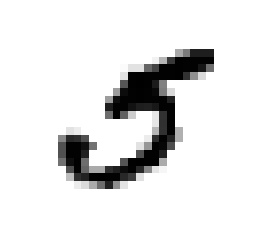

In [19]:
some_digit = X_full[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,interpolation="nearest")
plt.axis("off");

***A vous:*** Pourquoi $(1\heartsuit)$ `X_full.shape[1]=784`?

In [20]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

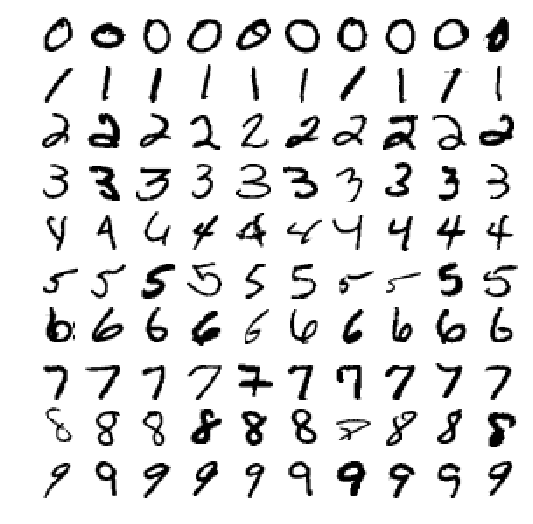

In [21]:
plt.figure(figsize=(9,9))
example_images = np.r_[X_full[:12000:600], X_full[13000:30600:600], X_full[30600:60000:590]]
plot_digits(example_images, images_per_row=10)

### train/test separation $\checkmark$

For short, we will write `X, X_test, y, y_test` instead of `X_train, X_test, y_train, y_test`

It is a checkpoint here: we wrap all previous data-preparation in a function 'get_trainTest_data', that we put on the  top.

In [62]:
np.random.seed(42)
perm=np.random.permutation(len(X_full))
X_rand=X_full[perm]
y_rand=y_full[perm]
X, X_test, y, y_test = X_rand[:60000], X_rand[60000:], y_rand[:60000], y_rand[60000:]

NameError: name 'np' is not defined

## Binary classifier $\hookleftarrow$ <a class="anchor" id="bin-clf"></a>

Let’s simplify the problem for now and only try to identify one digit — for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5.

In [63]:
%reset
#please recompile the first cell before reseting. 

In [65]:
X, X_test, y, y_test,some_digit=get_trainTest_data()

y_bin = (y == 5).astype(np.int)
y_bin_test = (y_test == 5).astype(np.int)
print(y_bin[:50])

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0]


Okay, now let’s pick a classifier and train it. A good place to start is with a Stochastic Gradient Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning), as we will see later. Let’s create an SGDClassifier and train it on the whole training set.

In [24]:
"""We want reproducible results, so set the random_state parameter"""
sgd_clf = sklearn.linear_model.SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X, y_bin)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Remark: we can observe all default parameters. We will explain them further on.  

In [25]:
sgd_clf.predict([some_digit])

array([1])

The classifier guesses that this image represents a 5 (Class 1). Looks like it guessed right in this particular case! Now, let’s evaluate this model’s performance.  

###  Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor.


###  accuracy on train 

accuracy (=exactitude) in the proportion of well classified. To compute it on train data is not a good measure of performance, but we do it anyway.  

In [26]:
y_bin_hat=sgd_clf.predict(X)
accuracy=np.mean(y_bin_hat==y_bin)
accuracy

0.9505166666666667

###  Accuracy Using Cross-Validation 

In [29]:
skfolds = sklearn.model_selection.StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X, y_bin):
    "copy the model with the same hyper-parameters"
    clone_clf = sklearn.base.clone(sgd_clf)
    clone_clf.fit(X[train_index], y_bin[train_index])
    y_pred = clone_clf.predict(X[test_index])
    print( np.mean(y_pred == y_bin[test_index]) ) 


0.9607
0.96185
0.9602


Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:  

In [33]:
def predict_always_0(X):
    return np.zeros(len(X))

skfolds = sklearn.model_selection.StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X, y_bin):
    clone_clf = sklearn.base.clone(sgd_clf)
    y_pred = predict_always_0(X[test_index])
    print( np.mean(y_pred == y_bin[test_index]) ) 

0.90995
0.90995
0.90995


That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5's. This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others). 

###  Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B.  To compute the confusion matrix, you first need to have a set of predictions, so they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now.

In [35]:

"a vector to store all predictions"
y_bin_hat=np.empty(len(y_bin),dtype=np.int)

skfolds = sklearn.model_selection.StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X, y_bin):
    clone_clf = sklearn.base.clone(sgd_clf)
    clone_clf.fit(X[train_index], y_bin[train_index])
    y_bin_hat[test_index] = clone_clf.predict(X[test_index])
print(y_bin_hat[:200])

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]


Now you are ready to get the confusion matrix: 

In [36]:
C=sklearn.metrics.confusion_matrix(y_bin, y_bin_hat)
"a dataframe just for presentation"
C_df=pd.DataFrame(data=C,columns=[r"$\hat -$",r"$\hat +$"],index=[r"$-$",r"$+$"])
C_df

,$\hat -$,$\hat +$
$-$,53594,1003
$+$,1342,4061


Each row in a confusion matrix represents an actual class, while each column represents a predicted class.  Symbol $+$ refer to the class we want to detect and is often the minority one. The predected $+$ are called the Positive, but they can be True Positive (=positive instance) of False positive:  
$$
\begin{array}{c|cc}
& \hat - & \hat + \\
\hline
- & TN & FP \\
+ & FN &  TP   
\end{array}
$$

In [37]:
TN=C[0,0]
FN=C[1,0]
FP=C[0,1]
TP=C[1,1];

***A vous:*** Indiquez  de tête quel est le résultat de  `confusion_matrix(y_train_5, y)` avec `y=y_train_5` $(1\heartsuit)$? et avec `y` un vecteur aléatoire de 0 et de 1 $(2\heartsuit)$?

The confusion matrix gives you a lot of information, but sometimes you may prefer more concise metrics: 
$$
\begin{align}
\text{precision} & =\frac{TP}{TP+FP}=  \frac{+\cap \hat +}{\hat +} = \text{accuracy of the positive predictions}\\
\text{recall} & =\frac{TP}{TP+FN} = \frac{+\cap \hat +}{ +} = \text{ratio of positive instances that are correctly detected}
\end{align}
$$

In [38]:
print("precision_score: %.2f"%(TP/(TP+FP)))
print("recall_score: %.2f"%(TP/(TP+FN)))

precision_score: 0.80
recall_score: 0.75


### F1 score

Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 80% of the time. Moreover, it only detects 75% of the 5s (moreover this score change when you change seeds). 

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall.
$$
F_1= \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}
$$

Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the secu« rity guards will get a few false alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall tradeoff. 


### Precision/Recall Tradeoff

To understand this tradeoff, let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class. 


Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then make predictions based on those scores using any threshold you want.

In [39]:
y_scores = sgd_clf.decision_function([some_digit])
print("y_scores:",y_scores)
threshold = 0
print("prediction:",  (y_scores > threshold))
threshold = 110000
print("prediction:",  (y_scores > threshold))

y_scores: [103362.83]
prediction: [ True]
prediction: [False]


In [41]:
skfolds = sklearn.model_selection.StratifiedKFold(n_splits=3, random_state=42)

"a vector to store all scores"
y_bin_score=np.empty(len(y_bin),dtype=np.float)

for train_index, test_index in skfolds.split(X, y_bin):
    clone_clf = sklearn.base.clone(sgd_clf)
    clone_clf.fit(X[train_index], y_bin[train_index])
    y_bin_score[test_index] = clone_clf.decision_function(X[test_index])
print(y_bin_score[:10])

[-567633.15 -433991.09 -618931.81  150637.99 -765078.16 -311250.28 -259925.   -356478.91 -337146.83 -751497.34]


(-700000, 700000)

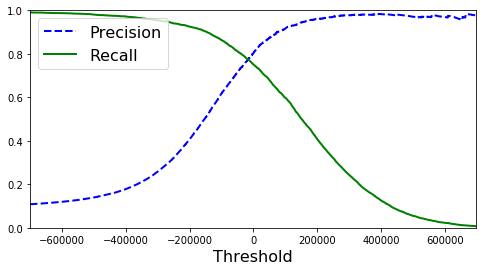

In [42]:

precisions, recalls, thresholds = sklearn.metrics.precision_recall_curve(y_bin, y_bin_score)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])

Now you can simply select the threshold value that gives you the best precision/recall tradeoff for your task. Another way to   select a good precision/recall tradeoff is to plot precision directly against recall:

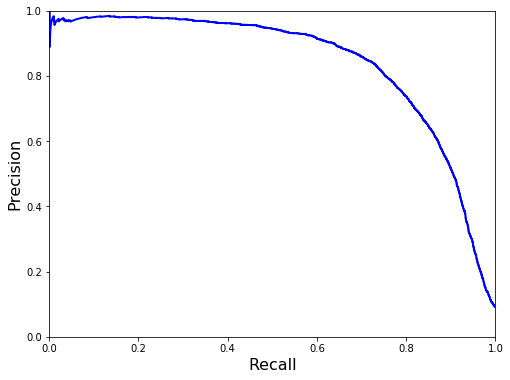

In [43]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

You can see that precision really starts to fall sharply around 80% recall. You will probably want to select a precision/recall tradeoff just before that drop — for example, at around 60% recall. But of course the choice depends on your project.
So let’s suppose you decide to aim for 90% precision. You look up the first plot (zooming in a bit) and find that you need to   use a threshold of about 70,000. To make predictions (on the training set for now), instead of calling the classifier’s `predict()` method, you can just run this code: 

In [44]:
y_bin_hat_90 = (y_bin_score > 70000).astype(np.int)
print("y_bin_hat_90\n",y_bin_hat_90[:200])
print("precision_score:",sklearn.metrics.precision_score(y_bin, y_bin_hat_90))
print("recall_score:",sklearn.metrics.recall_score(y_bin, y_bin_hat_90))

y_bin_hat_90
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0]
precision_score: 0.8912765413149143
recall_score: 0.6448269479918564


As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. Hmm, not so fast. A high-precision classifier is not very useful if its recall is too low.

***A vous:*** Trouvez $(3\heartsuit)$ un bon seuil en fonction du F1-score (Ne le faites pas à l'oeil).  Calculez la precision et le rapelle correspondant. 

###  The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate. 

* The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. 
$$

$$

$$
\begin{align}
\text{FPR=} & =\frac{TP}{TP+FP} = \text{accuracy of the positive predictions}\\

\text{TPR=recall=sensitivity} & =\frac{TP}{TP+FN} = \text{ratio of positive instances correctly detected}\\
\text{specificity} & =\frac{TN}{TN+FP} = \text{ratio of negative instances correctly detected}
\end{align}
$$


The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence the ROC curve plots sensitivity (recall) versus 1 – specificity. »

Extrait de: Aurélien Géron. « Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. » iBooks. 

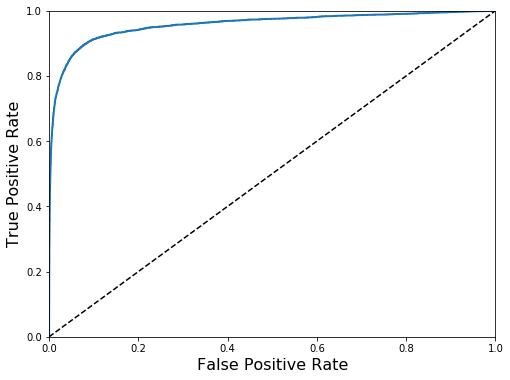

In [45]:

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_bin, y_bin_score)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

Once again there is a tradeoff: the higher the recall (TPR), the  more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).
One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. 

In [46]:
sklearn.metrics.roc_auc_score(y_bin, y_bin_score)

0.9572645142215492

### Which curve to choose? 

Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner). 

### Comparison with Random Forest

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier. Due to the way it works, the RandomForestClassifier class does not have a decision_function() method. Instead it has a predict_proba() method. Scikit-Learn classifiers generally have one or the other. The predict_proba() method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the  given class (e.g., 70% chance that the image represents a 5).

Extrait de: Aurélien Géron. « Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. » iBooks. 

Extrait de: Aurélien Géron. « Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. » iBooks. 

In [50]:
forest_clf = sklearn.ensemble.RandomForestClassifier(random_state=42)
skfolds = sklearn.model_selection.StratifiedKFold(n_splits=3, random_state=42)

"a vector to store all proba"
y_probas_forest=np.empty(shape=[len(y_bin),2],dtype=np.float)

for train_index, test_index in skfolds.split(X, y_bin):
    clone_clf = sklearn.base.clone(forest_clf)
    clone_clf.fit(X[train_index], y_bin[train_index])
    y_probas_forest[test_index,:] = clone_clf.predict_proba(X[test_index])
    
print(y_probas_forest[:10,:])

[[1.  0. ]
 [1.  0. ]
 [0.9 0.1]
 [0.4 0.6]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]]


But to plot a ROC curve, you need one scores, not two probabilities. A simple solution is to use the positive class’s probability as the score: 

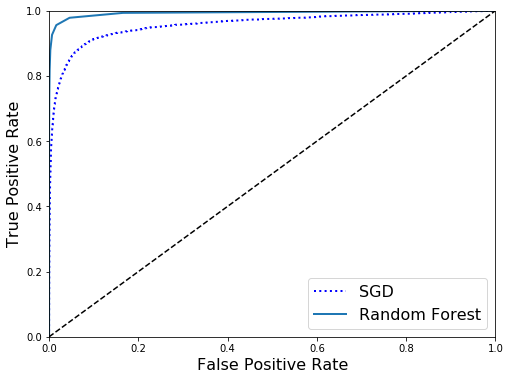

In [52]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = sklearn.metrics.roc_curve(y_bin,y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16);

As you can see, the RandomForestClassifier’s ROC curve looks much better than the SGDClassifier’s: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better: 

In [53]:
sklearn.metrics.roc_auc_score(y_bin, y_scores_forest)

0.9929158952316743

Hopefully you now know how to train binary classifiers, choose the appropriate metric for your task, evaluate your classifiers using cross-validation, select the precision/recall tradeoff that fits your needs, and compare various models using ROC curves and ROC AUC scores. Now let’s try to detect more than just the 5s.

##  Multiclass Classification $\hookleftarrow$

In [66]:
%reset 
"please: recompile the first cell after reseting"

'please: recompile the first cell after reseting'

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.
Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. However, there are two strategies that you can use to perform multiclass classification using multiple binary classifiers: 

* ***one-versus-all (OvA):*** you train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-all (OvA) strategy (also called one-versus-the-rest).

* ***one-versus-one (OvO):*** you train a binary classifier for every pair of  digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy.  

***A vous:*** S'il y a $N$ classes. Combien $(1\heartsuit)$ de classifier faut-il entrainer avec la stratégie OvO?

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA; except for SVM classifiers for which it uses OvO for theoritical reasons.

In [2]:
X, X_test, y, y_test,some_digit=get_trainTest_data()
sgd_clf = sklearn.linear_model.SGDClassifier(max_iter=5, random_state=42)

sgd_clf.fit(X, y)
sgd_clf.predict([some_digit])

array([5.])

Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score. To see that this is indeed the case, you can call the `decision_function()` method. Instead of returning just one score per instance, it now returns 10 scores, one per class:

In [3]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print("some_digit_scores:\n",some_digit_scores)
print("best:",np.argmax(some_digit_scores))
print("sgd_clf.classes_:",sgd_clf.classes_)

some_digit_scores:
 [[ -69004.81 -522013.14 -264110.73 -202938.59 -392780.34  103362.83 -708412.84 -244474.84 -771927.97 -758220.55]]
best: 5
sgd_clf.classes_: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


Training a `RandomForestClassifier` is just as easy: 

In [7]:
forest_clf=sklearn.ensemble.RandomForestClassifier(verbose=True)
forest_clf.fit(X, y)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

In [8]:
forest_clf.predict([some_digit])

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


array([5.])

In [9]:
forest_clf.predict_proba([some_digit])

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


array([[0.1, 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. ]])

You can see that the classifier is fairly confident about its prediction. Now of course you want to evaluate these classifiers. As usual, you want to use cross-validation. 

***A vous:*** Comparez $(3\heartsuit)$ les `accuracy` pour le `SGDClassifier` et le `RandomForestClassifier` en multi-classes. 


***A vous:*** Standardisez  les données puis recalculez $(3\heartsuit)$ les accuracy. Vous pouvez Standardisez à la main ou bien avec  `from sklearn.preprocessing import StandardScaler`. Remarquez que la standardisation s'effectue ici pixel par pixel. Affichez $(2\heartsuit)$ quelques images standardisée. 

###  Error Analysis

Of course, if this were a real project, you would follow the steps in your Machine Learning project checklist (see Appendix B): exploring data preparation options, trying out multiple models, shortlisting the best ones and fine-tuning their hyperparameters using GridSearchCV, and automating as much as possible.

Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to analyze the types of errors it makes.
First, you can look at the confusion matrix

In [13]:
y_pred=np.empty_like(y)
skfolds=sklearn.model_selection.StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X, y):
    clone_clf = sklearn.base.clone(sgd_clf)
    clone_clf.fit(X[train_index], y[train_index])
    y_pred[test_index] = clone_clf.predict(X[test_index])
    
print(y_pred[:200].astype(np.int))

[7 8 6 8 7 1 3 3 0 9 4 5 0 8 9 5 0 5 3 1 6 0 4 6 4 9 6 2 0 9 8 4 9 5 0 8 2 8 0 7 1 4 2 8 5 9 9 1 3 0 9 2 0 9 1 6 5 7 1 8 6 9 3 7 6 5 5 0 5 1 9 8 0 3 8 2 6 1 5 5 6 6 6 8 9 8 3 3 1 6 7 8 5 9 2 5 9 7 9 4 8 1 2 1 0 1 0 7 3 7 6 7 5 3 7 4 8 6 9 9 4 5 3 6 8 5 9 1 8 5 4 9 5 0 4 5 0 5 7 6 9 1 1 6 7 3 1 1 7 6 7 5 5 5 4 5 8 7 1 0 3 2 8 9 1 8 2 8 4 8 7 7 2 5 3 3 5 9 2 8 0 0 1 1 5 4 7 7 1 9 5 8 2 5 8 9 3 9 5 1]


In [15]:
print(y[:200].astype(np.int))

[7 8 6 5 7 1 3 3 0 9 4 5 0 2 0 5 0 5 3 1 6 0 4 6 4 8 6 2 0 9 8 4 7 5 0 8 2 8 0 7 1 4 2 8 5 9 5 1 3 0 9 2 0 4 1 6 8 7 1 8 6 9 3 7 6 5 5 0 5 1 9 8 0 3 8 2 6 1 5 5 6 6 6 8 9 8 3 5 1 6 7 8 5 8 2 3 9 7 9 4 8 1 2 1 0 1 0 7 3 7 6 7 5 3 7 4 4 6 9 9 4 5 3 6 8 3 4 1 8 5 4 9 5 0 4 5 0 5 7 6 4 1 1 6 7 3 1 7 7 6 7 5 5 5 4 5 3 7 1 0 3 2 8 9 1 8 2 8 4 8 7 7 2 3 3 3 5 7 2 8 0 0 1 1 5 4 7 2 1 4 5 8 2 5 8 9 3 9 5 1]


In [18]:
conf_mx = sklearn.metrics.confusion_matrix(y, y_pred)
print(conf_mx)

[[5421    3   78   30   10  105   36   40   99   52]
 [   1 6380   68   59    7   67    6   11   79   39]
 [  25   71 5265  122   58   79   68  109  183   46]
 [  13   28  320 4911    2  380   21   83  129  201]
 [  12   16   52   26 4660   60   48   86   93  800]
 [  34   36   66  270   40 4537   70   44  170  136]
 [  31   34   87    3   39  269 5331   29   51   26]
 [  10   22   91   24   31   16    4 5478   33  542]
 [  22  198  486  268   64  797   49  128 3638  249]
 [  19   23   38  160  137   71    4  560   43 4934]]


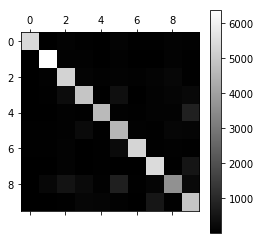

In [21]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.colorbar();

***Exo:*** 

*  $(3 \heartsuit)$ Divide  each value in the confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad). Aide: en notant $\imath$ le nombre d'instances de la classe $i$ et $\hat \imath$ le nombre d'instances prédites, il s'agit donc de tracer la matrice:
$
\frac {\imath \cap \hat \jmath}{\imath}
$
Aide: vous aurez à utiliser `np.sum(...,axis=...)`. 

* $(1 \heartsuit)$ En effectuant cette division, voit-on apparaitre la précision? le rappel?

* $(1 \heartsuit)$ Ajoutez des zéro sur la diagonal de la matrice ainsi obtenue, puis affichez le résultat plt.matshow()

* $(3 \diamondsuit)$  indiquez quelles sont les classes que le classifier confond. Quand il classe beaucoup de $\imath$ en $\jmath$, fait-il aussi l'erreur inverse: classer des $\jmath$ en $\imath$? 

* $(4 \diamondsuit)$. Montrez plein de digit que le classifier confond. Aide: utiliser la sélection par valeur: `X[mask]` où `mask` et un vecteur de booléen. 

Analyzing the confusion matrix can often give you insights on ways to improve your classifier. Looking at this plot, it seems that your efforts should be spent on improving classification of 8s and 9s, as well as fixing the specific 3/5 confusion. For example, you could try to gather more training data for these digits.  »

These confusions comme form the SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them. 

In [22]:
print(sgd_clf.coef_.shape)

(10, 784)


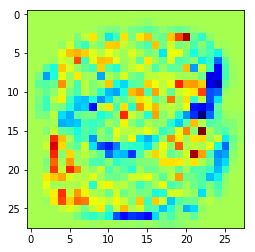

In [25]:
coef_3=(sgd_clf.coef_[3,:]).reshape([28,28])

plt.imshow(coef_3,cmap="jet")